# How to use `scivision`

In this notebook, we will:

1. Demonstrate using the scivision [Python API](https://scivision.readthedocs.io/en/latest/api.html) to load a pretrained (ImageNet) model, which we previously added to the scivision catalog with the name "scivision-test-plugin", as per [this guide](https://scivision.readthedocs.io/en/latest/contributing.html#extending-the-scivision-catalog)
2. Use the scivision catalog to find a matching dataset, which the model can be run on
3. Run the model on the data, performing simple model inference

Note: The model repository follows the strcuture specified in [this template](https://scivision.readthedocs.io/en/latest/model_repository_template.html), including a `scivision` [model config file](https://github.com/alan-turing-institute/scivision-test-plugin/blob/main/.scivision/model.yml).

We first import some things from scivision: `default_catalog` is a scivision **catalog** that will let us discover models and datasets, and `load_pretrained_model` provides a convenient way to load and run a model.

In [1]:
from scivision import default_catalog, load_pretrained_model

## Inspecting our model in the scivision catalog

A scivision catalog is a collection of **models** and **datasources**.

For this example, we want to find datasources compatible with "scivision-test-plugin".  But first, let's first let's use the catalog to retrive the "scivision-test-plugin" repository url, take a look at the other models in the *default catalog* (the built-in catalog, distributed as part of scivision) and see how this catalog is structured.

In [2]:
# Get the model repo url
models_catalog = default_catalog.models.to_dataframe()
stp_repo = models_catalog[models_catalog.name == "scivision-test-plugin"].url.item()
stp_repo # Why not paste the repo link into your browser and see how it looks?

AnyUrl('https://github.com/alan-turing-institute/scivision-test-plugin', scheme='https', host='github.com', tld='com', host_type='domain', path='/alan-turing-institute/scivision-test-plugin')

In [3]:
# Inspecting models in the default catalog
default_catalog.models.to_dataframe().head()

,name,description,tasks,url,pkg_url,format,pretrained,labels_required,institution,tags
0,model-000,None,"(TaskEnum.object_detection, TaskEnum.segmentat...",https://github.com/stardist/stardist,git+https://github.com/stardist/stardist.git@main,image,True,True,"(epfl,)","(2D, 3D, optical-microscopy, xray, microtomogr..."
1,model-001,None,"(TaskEnum.segmentation, TaskEnum.thresholding,...",https://github.com/danforthcenter/plantcv,git+https://github.com/danforthcenter/plantcv@...,image,True,True,"(danforthcenter,)","(2D, hyperspectral, multispectral, near-infrar..."
2,model-002,None,"(TaskEnum.segmentation,)",https://github.com/MarniTausen/Greenotyper,git+https://github.com/MarniTausen/Greenotyper...,image,True,True,"(MarniTausen,)","(2D, multispectral, plant-phenotyping, climate..."
3,model-003,None,"(TaskEnum.segmentation,)",https://github.com/alan-turing-institute/cv-al...,git+https://github.com/alan-turing-institute/c...,image,True,True,"(alan-turing-institute,)","(dummy,)"
4,scivision-test-plugin,None,"(TaskEnum.object_detection,)",https://github.com/alan-turing-institute/scivi...,git+https://github.com/alan-turing-institute/s...,image,True,False,"(alan-turing-institute,)","(dummy,)"


## Loading the model

Next, let's load the "scivision-test-plugin" model using the scivision python API, specifically the `load_pretrained_model` function:

In [4]:
model = load_pretrained_model(stp_repo, allow_install=True)

In [5]:
# let's explore the model object
model

scivision.PretrainedModel( 
  module='scivision_test_plugin', 
  model='ImageNetModel', 
  source='https://github.com/alan-turing-institute/scivision-test-plugin.git' 
  pipe='DataPipe(input=<Parameter "X: numpy.ndarray">, output=<Parameter "image: numpy.ndarray">)' 
)

Later, we'll use this ImageNet model to make predictions on image data found in the scivision catalog.

## Query the default scivision catalog

Now let's use the `default_catalog` to identify datasources in the catalog that are compatible with the model (based on `tasks`, `format` and `labels_provided`/`labels_required`).

In [6]:
compatible_datasources = default_catalog.compatible_datasources("scivision-test-plugin").to_dataframe()
compatible_datasources

,name,description,tasks,domains,url,format,labels_provided,institution,tags
0,data-000,None,"(TaskEnum.object_detection, TaskEnum.segmentat...","(optical-microscopy,)",https://github.com/stardist/stardist/releases/...,image,True,"(epfl,)","(help-needed, 3D, cell, cell-counting, biology..."
1,data-001,None,"(TaskEnum.segmentation, TaskEnum.thresholding,...","(multispectral, hyperspectral)",https://gitlab.au.dk/AUENG-Vision/OPPD/-/archi...,image,True,"(Aarhus University,)","(help-needed, 2D, plant-phenotyping, agricultu..."
3,data-003,Koala,"(TaskEnum.object_detection,)","(computer-vision,)",https://github.com/alan-turing-institute/scivi...,image,True,"(Wikipedia by Erik Veland,)","(demo,)"


Let's use `data-003`, a single image dataset (of a baby Koala!)

In [7]:
target_datasource = compatible_datasources.loc[compatible_datasources['name'] == 'data-003']
target_datasource

,name,description,tasks,domains,url,format,labels_provided,institution,tags
3,data-003,Koala,"(TaskEnum.object_detection,)","(computer-vision,)",https://github.com/alan-turing-institute/scivi...,image,True,"(Wikipedia by Erik Veland,)","(demo,)"


## Load the dataset

Now let's load the dataset using the scivision python API, specifically the [load_dataset](https://scivision.readthedocs.io/en/latest/api.html#scivision.io.reader.load_dataset) function, which takes as input the url of the data repository (structured as per [this template](https://scivision.readthedocs.io/en/latest/data_repository_template.html)), which we can get from the target datasource:

In [8]:
from scivision import load_dataset

In [9]:
data_url = target_datasource['url'].item()

The returned data config object of the`load_dataset` function is an "intake catalog". You can read our [documentation](https://scivision.readthedocs.io/en/latest/data_repository_template.html#data-config-file) to understand this better, but for now, let's inspect this config:

In [10]:
data_config = load_dataset(data_url)
data_config

data:
  args:
    path: https://raw.githubusercontent.com/alan-turing-institute/scivision-test-data/main/.scivision/data.yml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


Clicking the `path` link to the location of this data config file online (in the dataset repo) reveals that there is one data source called `test_image`, and that the `intake_xarray.image.ImageSource` is being used. We can retrive the test image data in an image format which the model will accept, like so:

In [11]:
test_image = data_config.test_image().to_dask() # The xarray.DataArray is one format accepted by the ImageNet model
test_image

/opt/anaconda3/lib/python3.7/site-packages/xarray/core/dataset.py:2178: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  category=FutureWarning,


<xarray.DataArray (y: 240, x: 262, channel: 3)>
dask.array<xarray-<this-array>, shape=(240, 262, 3), dtype=uint8, chunksize=(240, 262, 3), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 231 232 233 234 235 236 237 238 239
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 253 254 255 256 257 258 259 260 261
  * channel  (channel) int64 0 1 2

Let's take a look at the image with `matplotlib`:

In [12]:
import matplotlib.pyplot as plt

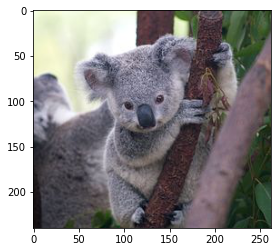

In [13]:
plt.imshow(test_image)

## Model predictions

Now let's use the loaded model on the test image data we found in the via catalog.

In [14]:
model.predict(test_image)

'koala : 99.80%'

As you can see, this model has given a prediction of the test image, with a confidence score. Check out the code in the model repo to see how this was determined!